In [3]:
import pandas as pd
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score,recall_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV,ParameterGrid
import warnings; warnings.simplefilter('ignore')
from sklearn.ensemble import VotingClassifier
import pickle
%matplotlib inline
sns.set()
sns.set_style('whitegrid', {'axes.grid' : False})

In [9]:
# Import data and create one dataframe
df_1 = pd.read_csv('sql_export_retention_v2.csv')
df_2 = pd.read_csv('sql_export_connections_v2.csv')
df_3 = pd.read_csv('export_payments_v2.csv')
df_4 = pd.read_csv ('sql_export_chat_requests_received_v2.csv')
df_5 = pd.read_csv('sql_export_chat_requests_sent_v2.csv')
df_6 = pd.read_csv('sql_export_crons_spent_v2.csv')
df_7 = pd.read_csv('sql_export_rating_given_v2.csv')
df_8 = pd.read_csv('sql_export_rating_received_v2.csv')
banned = pd.read_csv('banned_since_jan19_2020_03_03.csv')
df = reduce(lambda  left,right: pd.merge(left,right,on=['user_id'],how='outer'), [df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8])

# Cleaning

In [10]:
## Missing values
df.isna().sum()
### Dropping 1 row without user_id
df.drop(df[df.user_id.isna()].index,axis=0, inplace=True)
### user_gender : drop nan
missing_gender = df[df.user_gender.isna()]
df.drop(df[df.user_gender.isna()].index,axis=0, inplace=True)
### user_country : 1 missing value : check in db seems to be in Africa/Windhoek time zone so filled with NA (Namibia)
df.user_country.fillna('NA', inplace = True)
### max_match_num : this col is nan when the user has not made anny connection during the 5 first days => fill with 0
df.max_match_num.fillna(0, inplace = True)
### max_connection_num: this col is nan when the user has not made anny connection during the 5 first days => fill with 0
df.max_connection_num.fillna(0, inplace = True)
### payments : the 4 payment columns are nan when the user has not made any purchase during the 5 first days => fill with 0
df.crowns_usd_5d.fillna(0, inplace = True)
df.sub_usd_5d.fillna(0, inplace = True)
df.sub_re_usd_5d.fillna(0, inplace = True)
df.discount_usd_5d.fillna(0, inplace = True)
### payments : replace subscription renewal by subscription 
df['sub_usd_5d'] = df.eval('sub_usd_5d + sub_re_usd_5d')
df.drop('sub_re_usd_5d', axis=1, inplace=True)
### chat requests : same as previous=> fill with 0
df.chat_request_received_5d.fillna(0, inplace = True)
df.chat_request_sent_5d.fillna(0, inplace = True)
### crowns spent : same as previous
df.crowns_spent_chat_5d.fillna(0, inplace = True)
df.crowns_spent_message_5d.fillna(0, inplace = True)
df.crowns_spent_match_now_5d.fillna(0, inplace = True)
df.crowns_spent_discover_5d.fillna(0, inplace = True)
df.crowns_spent_pick_5d.fillna(0, inplace = True)
df.crowns_spent_instant_match_now_5d.fillna(0, inplace = True)
df.crowns_spent_more_pick_5d.fillna(0, inplace = True)
df.crowns_spent_average_rating_5d .fillna(0, inplace = True)
df.crowns_spent_another_5d.fillna(0, inplace = True)
df.crowns_spent_curated_user_5d.fillna(0, inplace = True)
df.crowns_spent_curated_user_attractive_5d.fillna(0, inplace = True)
df.crowns_spent_curated_user_close_5d.fillna(0, inplace = True)
df.crowns_spent_curated_user_serious_5d.fillna(0, inplace = True)
df.crowns_spent_curated_user_new_5d.fillna(0, inplace = True)
df.crowns_spent_curated_user_alone_5d.fillna(0, inplace = True)
df.crowns_spent_more_rating_5d .fillna(0, inplace = True)
df.crowns_spent_rematch_5d .fillna(0, inplace = True)
df.crowns_spent_reset_rating_5d.fillna(0, inplace = True)
df.crowns_spent_pick_from_ratings_5d.fillna(0, inplace = True)
df.crowns_spent_stalk_5d.fillna(0, inplace = True)
### ratings : same as previous
df.rating_given.fillna(0, inplace = True)
df.avg_rating_given .fillna(0, inplace = True)
df.rating_received.fillna(0, inplace = True)
df.avg_rating_received.fillna(0, inplace = True)

# Create a total login column
df['login_5d']= df.eval('1+d1+d2+d3+d4')
# Create a total spent column and a has_spent columns
df['total_spent']=df.eval('crowns_usd_5d+sub_usd_5d+discount_usd_5d')
df['has_spent']=df.total_spent.apply(lambda x: 1 if x>0 else 0)
# Create a total crowns_spent column
df['total_crowns_spent'] = df.eval ('crowns_spent_chat_5d+crowns_spent_message_5d+crowns_spent_match_now_5d+crowns_spent_discover_5d+crowns_spent_pick_5d+crowns_spent_instant_match_now_5d+crowns_spent_more_pick_5d+crowns_spent_average_rating_5d+crowns_spent_another_5d+crowns_spent_curated_user_5d+crowns_spent_curated_user_attractive_5d+crowns_spent_curated_user_close_5d+ crowns_spent_curated_user_serious_5d+ crowns_spent_curated_user_new_5d+ crowns_spent_curated_user_alone_5d+ crowns_spent_more_rating_5d+ crowns_spent_rematch_5d+crowns_spent_reset_rating_5d+ crowns_spent_pick_from_ratings_5d+ crowns_spent_stalk_5d')

# Countries
def countries(x):
    top_lst = ['FR','IT', 'DE', 'BR', 'BE', 'CH', 'US', 'GB', 'AT', 'NL', 'CA']
    eur_lst = ['AL', 'AD', 'AM', 'BY', 'BA', 'BG', 'CY','CZ', 'DK', 'EE', 'ES', 'FO', 'FI',
               'GI','GR', 'HU', 'HR', 'IE', 'IS', 'LI', 'LT', 'LU', 'LV', 'MC', 'MK', 'MT', 'NO', 'PL', 'PT', 'RO', 'RU', 'SE', 'SI', 'SK', 'SM', 'TR', 'UA', 'VA']
    asia_lst = ['CN', 'YE', 'IN','AU','NZ', 'HK', 'JP', 'AF', 'AZ', 'BH', 'BD', 'BT', 'BN', 'KH', 'GE', 'ID', 'IR', 'IQ', 'IL', 'JO', 'KZ', 'KW', 'KG', 'LA', 'LB', 'MO', 'MY', 'MV', 'MN', 'MM', 'NP', 'KP', 'OM', 'PK', 'PH', 'QA', 'SA', 'SG', 'KR', 'LK', 'SY', 'TW', 'TJ', 'TH', 'TM', 'AE', 'UZ', 'VN']
    africa_lst = ['MA', 'CI','RE', 'DZ', 'NG', 'EG', 'TN','AE']
    southam_lst = ['MX','AR', 'CO','CL','PE', 'BO', 'BR', 'VG', 'CR', 'CU', 'CW', 'DM', 'DO', 'EC', 'SV', 'FK', 'GL', 'GP', 'GT', 'GY', 'HT', 'JM', 'NI', 'PA', 'PY', 'PR', 'BL', 'KN', 'LC', 'MF', 'PM', 'VC', 'SR', 'TT', 'UY', 'VE']
    if x in top_lst :
        return x
    elif x in eur_lst:
        return 'other EU'
    elif x in asia_lst:
        return 'other Asia'
    elif x in africa_lst:
        return 'other Africa'
    elif x in southam_lst:
        return 'other South America'
    else :
        return 'other'
df['country']= df.user_country.apply(lambda x: countries(x))
df.drop('user_country', axis=1, inplace=True)

# Acquisition
def paid(x):
    if x in ['Organic', 'Google Organic Search']:
        return 0
    else :
        return 1
df['paid_user'] = df.network.apply(lambda x: paid(x))
df.drop('network', axis=1, inplace=True)

# Drop the "curated" crowns spending types because new feature
col_drop = ['crowns_spent_curated_user_5d','crowns_spent_curated_user_attractive_5d','crowns_spent_curated_user_close_5d','crowns_spent_curated_user_serious_5d', 'crowns_spent_curated_user_new_5d', 'crowns_spent_curated_user_alone_5d']
df.drop(col_drop, axis=1, inplace=True)

# Drop banned accounts
banned['status']= 'banned'
banned.rename ( columns = {'Id' : 'user_id'}, inplace=True)
df = df.merge(banned, on='user_id', how='left')
df.drop(df[df['status']=='banned'].index, inplace = True)
df.drop('status', axis=1, inplace= True)

# Data Processing

In [11]:
df1=df.copy()
# Remove unecessary columns
col_remove= ['install_date', 'user_id', 'max_match_num','total_spent', 'has_spent', 'total_crowns_spent']
df1.drop(col_remove, axis=1, inplace=True)
# Age create bins
df1['age']= pd.cut(df1['user_age'], [18, 28, 38, 48,150], labels = [ '18_28','29-38', '38-48', 'more than 48'])
df1.drop('user_age', axis=1, inplace=True)
# Create dummies
col_dummies=['user_platform', 'country', 'age']
df1 = pd.get_dummies(data=df1, columns=col_dummies, drop_first=True)

# Transform crowns_usd_5d, sub_usd_5d, discount_usd_5d into dummies
df1['crowns_usd_5d']= df1.crowns_usd_5d.apply(lambda x: 1 if x>0 else 0)
df1['sub_usd_5d']= df1.sub_usd_5d.apply(lambda x: 1 if x>0 else 0)
df1['discount_usd_5d']= df1.discount_usd_5d.apply(lambda x: 1 if x>0 else 0)

# Transform connection into dummies
df1['connection']= df1.max_connection_num.apply(lambda x: 1 if x>0 else 0)
df1.drop('max_connection_num', axis=1, inplace=True)

# drop columns with low values and d1, d2, d3, d4 , login_w& that are providing the same info as login_5d
col_drop2 = ['d1', 'd2','d3', 'd4','crowns_spent_average_rating_5d','crowns_spent_another_5d','crowns_spent_more_rating_5d','crowns_spent_rematch_5d','crowns_spent_reset_rating_5d','crowns_spent_pick_from_ratings_5d','crowns_spent_stalk_5d', 'paid_user']
df1.drop(col_drop2, axis=1, inplace=True)

# Transformcrowns usage columns into dummies
crown_lst =['connection','crowns_spent_chat_5d','crowns_spent_message_5d','crowns_spent_match_now_5d','crowns_spent_discover_5d', 'crowns_spent_pick_5d','crowns_spent_instant_match_now_5d', 'crowns_spent_more_pick_5d']
for i in crown_lst:
    df1[i]= df1[i].apply(lambda x: 1 if x>0 else 0)


# split into 2 df : Men / Women
df1_m = df1[df1.user_gender=='m']
df1_w = df1[df1.user_gender=='w']

# WORKING ON WOMEN
df1_w.drop(['user_gender'], axis=1, inplace=True)
# drop discount discount_usd_5d because only 0
df1_w.drop(['discount_usd_5d'], axis=1, inplace=True)

# Winsorize
winsorize(df1_w.rating_given,limits=[0,0.05],inplace=True)
winsorize(df1_w.rating_received,limits=[0,0.05],inplace=True)
winsorize(df1_w.chat_request_received_5d,limits=[0,0.05],inplace=True)
winsorize(df1_w.chat_request_sent_5d,limits=[0,0.05],inplace=True)


# Scaling : creating of a df with scaled columns
scaler = StandardScaler()
df1_w[['login_5d','chat_request_received_5d','chat_request_sent_5d','avg_rating_given','avg_rating_received', 'rating_given', 'rating_received']] = scaler.fit_transform(df1_w[['login_5d','chat_request_received_5d','chat_request_sent_5d','avg_rating_given','avg_rating_received', 'rating_given', 'rating_received']])

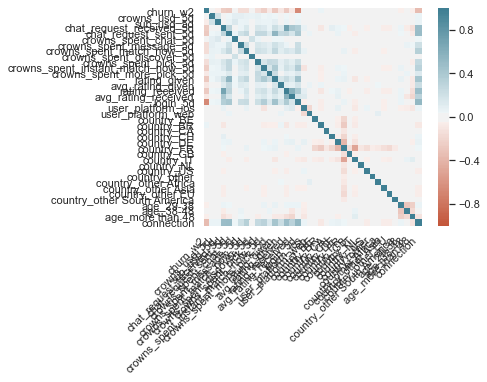

In [12]:
# Correlation matrix
# Matrix
correlation = df1_w.corr()

# Plotting
ax = sns.heatmap(
    correlation, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    xticklabels=True, 
    yticklabels=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# Model

In [13]:
# Using the statsmodel logistic regression to detect the most important variables
X=df1_w.drop('churn_w2', axis=1).copy()
X.reset_index(inplace=True, drop = True)
y = df1_w['churn_w2']
y.reset_index(inplace=True, drop = True)
model1=sm.Logit(y,X)
result1=model1.fit()
print(result1.summary2())

Optimization terminated successfully.
         Current function value: 0.395039
         Iterations 7
                                  Results: Logit
Model:                     Logit                 Pseudo R-squared:      0.391     
Dependent Variable:        churn_w2              AIC:                   32373.1976
Date:                      2020-04-07 21:43      BIC:                   32692.0791
No. Observations:          40881                 Log-Likelihood:        -16150.   
Df Model:                  36                    LL-Null:               -26497.   
Df Residuals:              40844                 LLR p-value:           0.0000    
Converged:                 1.0000                Scale:                 1.0000    
No. Iterations:            7.0000                                                 
----------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------

In [14]:
# Removing the columns for which p_value is higher than 0.05
cols =['crowns_usd_5d','crowns_spent_chat_5d', 'crowns_spent_message_5d','crowns_spent_discover_5d',\
       'crowns_spent_pick_5d','crowns_spent_instant_match_now_5d','user_platform_web', 'country_other', 'connection'] 
X.drop(cols, axis=1, inplace=True)

In [15]:
#splitting train and test data
X1_train, X1_test, y1_train, y1_test = train_test_split(X,y,test_size=0.3, random_state=42, stratify=y)

# Function attribute
#Algorithm     - Algorithm used 
#training_x    - predictor variables dataframe(training)
#testing_x     - predictor variables dataframe(testing)
#training_y    - target variable(training)
#training_y    - target variable(testing)
#cf - ["coefficients","features"](cooefficients for logistic regression,features for tree based models)

def churn_prediction(algorithm,training_x,testing_x,training_y,testing_y,cols,cf):
    # model
    algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    #coeffs
    if   cf == "coefficients" :
        coefficients  = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == "features" :
        coefficients  = pd.DataFrame(algorithm.feature_importances_)
    column_df= pd.DataFrame(cols)
    coef_sumry= (pd.merge(coefficients,column_df,left_index= True,right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy Score : ",accuracy_score(testing_y,predictions))
    print ("Recall Score : ",recall_score(testing_y,predictions))
    print("Precision Score : ",precision_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
    
    #plot confusion matrix
    plt.figure()
    matrix =sns.heatmap(conf_matrix, annot=True, fmt="d")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    matrix.set_xticklabels(['No churn', 'Churn'])
    matrix.set_yticklabels(['No churn', 'Churn'])
    matrix.set_title('Confusion matrix')

    #plot roc curve
    fpr,tpr,thresholds=roc_curve(testing_y, probabilities[:,1])
    plt.figure()
    plt.plot(fpr,tpr,label=f'Roc (area={model_roc_auc})')
    plt.plot([0,1],[0,1])
    plt.legend()
    plt.title('Model performance')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.show()
    #plot coeffs
    plt.figure()
    coef_plot= sns.barplot(x = coef_sumry["features"],y = coef_sumry["coefficients"])
    coef_plot.set_title=('Features importance')
    coef_plot.set_xticklabels(coef_plot.get_xticklabels(), rotation = 90)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.75      0.78      0.77      4307
         1.0       0.88      0.86      0.87      7958

    accuracy                           0.83     12265
   macro avg       0.82      0.82      0.82     12265
weighted avg       0.84      0.83      0.83     12265

Accuracy Score :  0.8339991846718304
Recall Score :  0.8611460165870822
Precision Score :  0.8803956834532374
Area under curve :  0.8224931383144374 



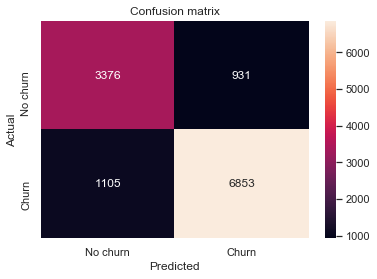

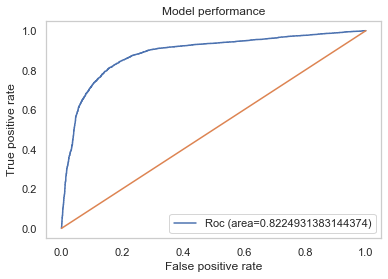

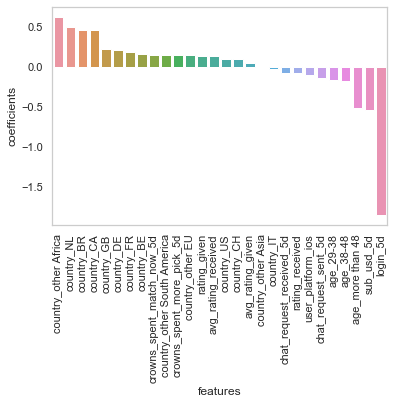

In [16]:
# Model 1 : logistic regression default
logit = LogisticRegression()
churn_prediction(logit,X1_train,X1_test,y1_train, y1_test,X.columns,'coefficients')

In [18]:
## Feature Engineering : RFE
logit2= LogisticRegression(max_iter=100)
selector = RFE(logit2,15)
selector = selector.fit(X,y)
selector.ranking_
selector.support_

idc_rfe = pd.DataFrame({'rfe_support' : selector.support_, 'columns' : X.columns, 'ranking' :selector.ranking_ })
selected_cols = idc_rfe['columns'][idc_rfe['rfe_support']==True].tolist()
X1 = X[selected_cols]

## Feature engineering : PCA
pca = PCA(0.9)
pca.fit(X)
print(pca.explained_variance_ratio_)
X1_PCA =pca.transform(X1_train)

[0.34360052 0.15821467 0.10594937 0.07787924 0.06359024 0.04841852
 0.03297103 0.03148474 0.02715441 0.02608865]


In [19]:
X1.columns

Index(['sub_usd_5d', 'crowns_spent_more_pick_5d', 'login_5d', 'country_BE',
       'country_BR', 'country_CA', 'country_DE', 'country_FR', 'country_GB',
       'country_NL', 'country_US', 'country_other Africa', 'country_other EU',
       'country_other South America', 'age_more than 48'],
      dtype='object')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.75      0.79      0.77      4307
         1.0       0.88      0.86      0.87      7958

    accuracy                           0.83     12265
   macro avg       0.82      0.82      0.82     12265
weighted avg       0.84      0.83      0.83     12265

Accuracy Score :  0.8340807174887892
Recall Score :  0.8598894194521236
Precision Score :  0.8814891150328481
Area under curve :  0.8231418306919314 



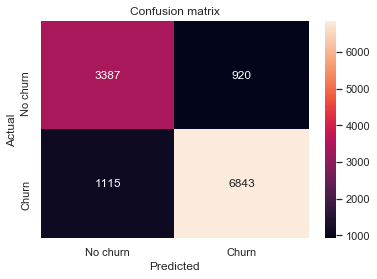

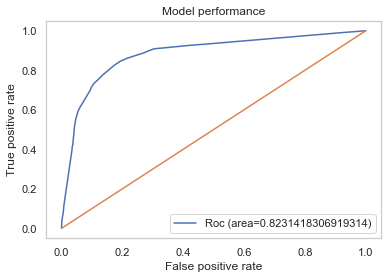

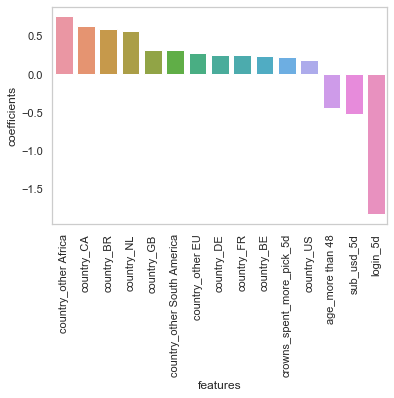

In [20]:
# Model 2 : logitstic regression with RFE
X2_train, X2_test, y2_train, y2_test = train_test_split(X1,y,test_size=0.3, random_state=42, stratify=y)
churn_prediction(logit,X2_train,X2_test,y2_train, y2_test,X1.columns,'coefficients')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.75      0.79      0.77      4307
         1.0       0.88      0.86      0.87      7958

    accuracy                           0.83     12265
   macro avg       0.82      0.82      0.82     12265
weighted avg       0.84      0.83      0.84     12265

Accuracy Score :  0.8347329800244598
Recall Score :  0.8600150791656195
Precision Score :  0.8822998581926003
Area under curve :  0.8240172911500261 



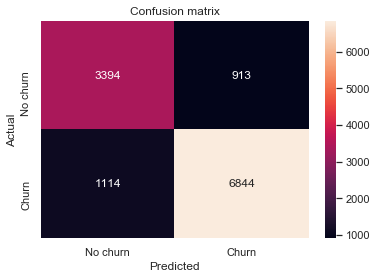

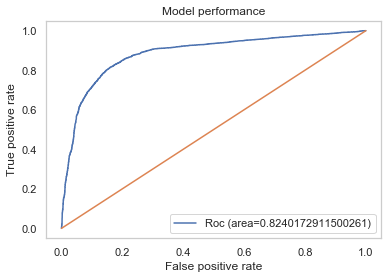

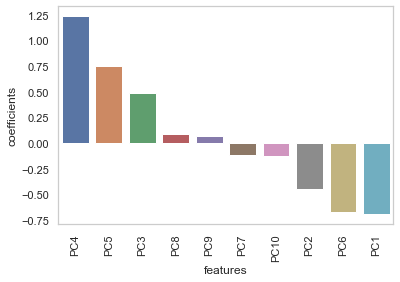

In [21]:
# Model3: logitstic regression with PCA
pca_col = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12']
churn_prediction(logit,X1_PCA,pca.transform(X1_test),y1_train, y1_test,pca_col,'coefficients')

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.65      0.66      0.65      4307
         1.0       0.81      0.80      0.81      7958

    accuracy                           0.75     12265
   macro avg       0.73      0.73      0.73     12265
weighted avg       0.75      0.75      0.75     12265

Accuracy Score :  0.7529555646147574
Recall Score :  0.804724805227444
Precision Score :  0.8126903553299493
Area under curve :  0.7310134358154867 



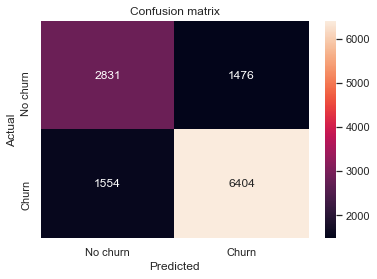

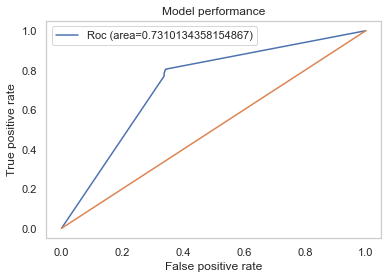

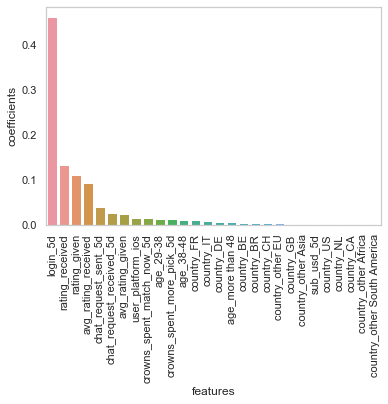

In [22]:
# Model 4 : Decision tree without Feature Engineering
decision = DecisionTreeClassifier()
churn_prediction(decision,X1_train,X1_test,y1_train, y1_test,X.columns,'features')

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.79      0.72      0.75      4307
         1.0       0.85      0.89      0.87      7958

    accuracy                           0.83     12265
   macro avg       0.82      0.80      0.81     12265
weighted avg       0.83      0.83      0.83     12265

Accuracy Score :  0.8314716673461068
Recall Score :  0.8944458406634833
Precision Score :  0.8529658478130617
Area under curve :  0.8047803849242655 



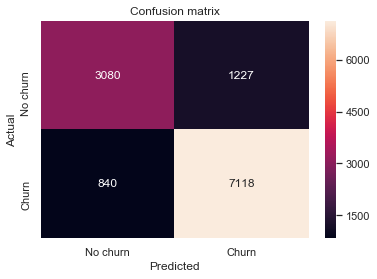

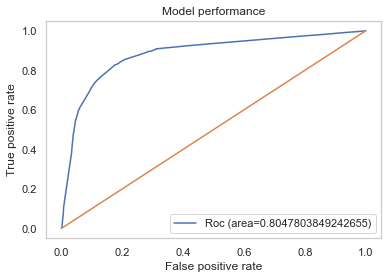

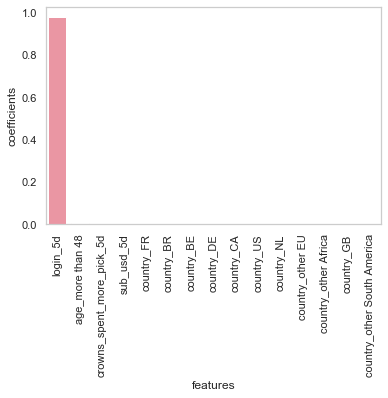

In [23]:
# Model 5 : Decision tree with RFE
churn_prediction(decision,X2_train,X2_test,y2_train, y2_test,X1.columns,'features')

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.64      0.65      0.65      4307
         1.0       0.81      0.81      0.81      7958

    accuracy                           0.75     12265
   macro avg       0.73      0.73      0.73     12265
weighted avg       0.75      0.75      0.75     12265

Accuracy Score :  0.7509172441907868
Recall Score :  0.807363659210857
Precision Score :  0.8084811878696363
Area under curve :  0.7269927188554866 



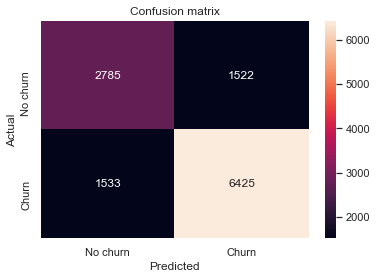

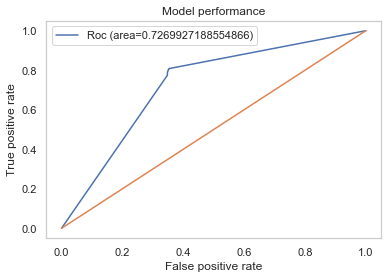

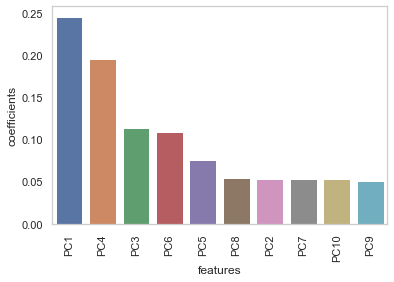

In [24]:
# Model 6: Decision tree with PCA
churn_prediction(decision,X1_PCA,pca.transform(X1_test),y1_train, y1_test,pca_col,'features')

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.76      0.75      0.75      4307
         1.0       0.87      0.87      0.87      7958

    accuracy                           0.83     12265
   macro avg       0.81      0.81      0.81     12265
weighted avg       0.83      0.83      0.83     12265

Accuracy Score :  0.828128821850795
Recall Score :  0.8703191756722795
Precision Score :  0.865533

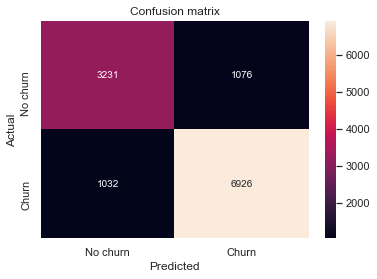

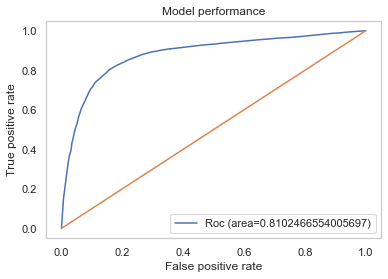

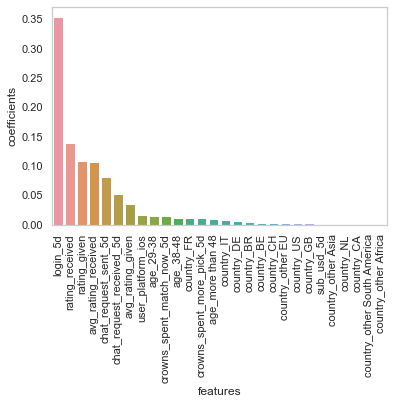

In [31]:
# Model 7 : Random Forest without Feature Engineering
forest = RandomForestClassifier()
churn_prediction(forest,X1_train,X1_test,y1_train, y1_test,X.columns,'features')

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.79      0.71      0.75      4307
         1.0       0.85      0.90      0.87      7958

    accuracy                           0.83     12265
   macro avg       0.82      0.80      0.81     12265
weighted avg       0.83      0.83      0.83     12265

Accuracy Score :  0.8303302079086833
Recall Score :  0.8963307363659211
Precision Score :  0.85028

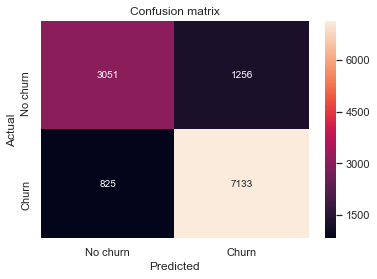

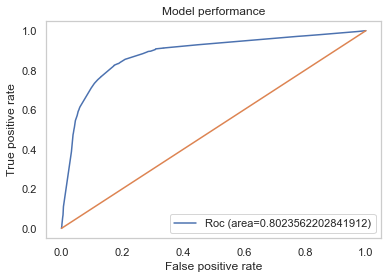

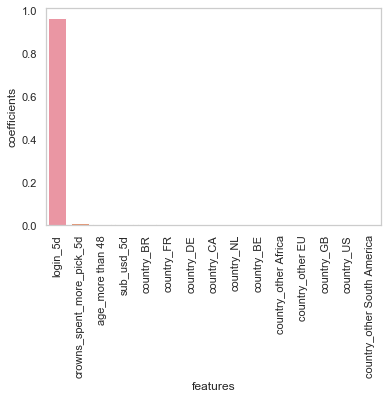

In [32]:
# Model 8: Random Forest with RFE
churn_prediction(forest,X2_train,X2_test,y2_train, y2_test,X1.columns,'features')

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.74      0.77      0.75      4307
         1.0       0.87      0.86      0.86      7958

    accuracy                           0.82     12265
   macro avg       0.81      0.81      0.81     12265
weighted avg       0.83      0.82      0.82     12265

Accuracy Score :  0.8238075825519772
Recall Score :  0.8553656697662729
Precision Score :  0.87079

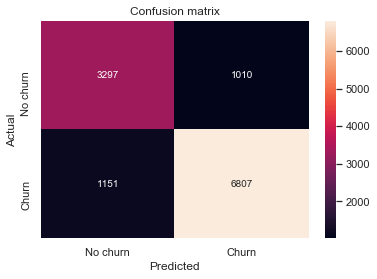

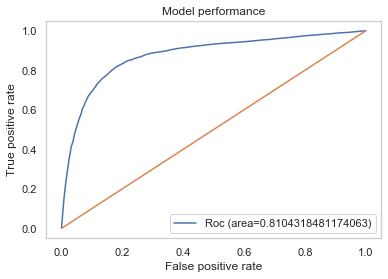

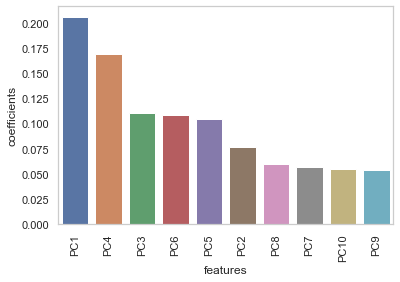

In [33]:
# Model 9: Random Forest with PCA
churn_prediction(forest,X1_PCA,pca.transform(X1_test),y1_train, y1_test,pca_col,'features')

In [10]:
# KNN : creation of a fucntion to run the model and display the results
def churn_prediction2(algorithm,training_x,testing_x,training_y,testing_y):
    # model
    algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
        
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    print ("Recall Score : ",recall_score(testing_y,predictions))
    print("Precision Score : ",precision_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
    
    #plot confusion matrix
    plt.figure()
    matrix =sns.heatmap(conf_matrix, annot=True, fmt="d")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    matrix.set_xticklabels(['No churn', 'Churn'])
    matrix.set_yticklabels(['No churn', 'Churn'])
    matrix.set_title('Confusion matrix')

    #plot roc curve
    fpr,tpr,thresholds=roc_curve(testing_y, probabilities[:,1])
    plt.figure()
    plt.plot(fpr,tpr,label=f'Roc (area={model_roc_auc})')
    plt.plot([0,1],[0,1])
    plt.legend()
    plt.title('Model performance')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.show()

In [11]:
# KNN : creation of a function that displays the best number of neighbors for highest recall score
### Find the best number of neighbors
def best_neigh(training_x,testing_x,training_y,testing_y) :
    precision = []
    for k in range(3,15,2):
        model = KNeighborsClassifier(k)
        precision.append(recall_score(testing_y, model.fit(training_x, training_y).predict(testing_x)))
    plt.plot(range(3,15,2), precision, 'o-')
    plt.title('Recall according to number of neighbours')
    plt.xlabel('Number of neighbours')
    plt.ylabel('Recall')
    plt.show()

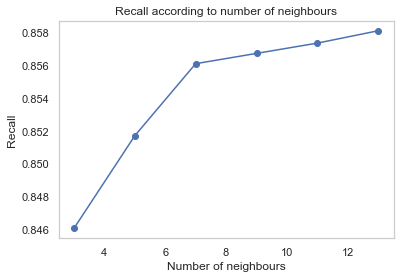

In [36]:
# KNN without feature engineering
best_neigh(X1_train,X1_test,y1_train, y1_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                     weights='uniform')

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.75      0.77      0.76      4307
         1.0       0.87      0.86      0.87      7958

    accuracy                           0.83     12265
   macro avg       0.81      0.81      0.81     12265
weighted avg       0.83      0.83      0.83     12265

Accuracy   Score :  0.8264166326946596
Recall Score :  0.8581301834631817
Precision Score :  0.8722697662536723
Area under curve :  0.8129750058249272 



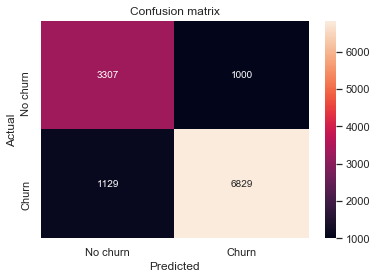

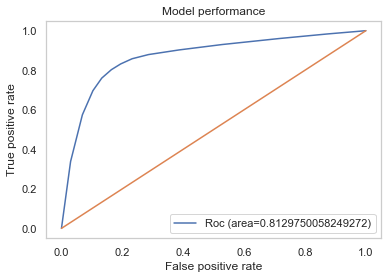

In [37]:
# Model 10 : KNN without feature engineering
knn= KNeighborsClassifier(13)
churn_prediction2(knn,X1_train,X1_test,y1_train, y1_test)

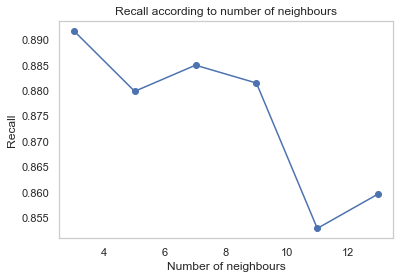

In [38]:
# KNN with RFE
best_neigh(X2_train,X2_test,y2_train,y2_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.77      0.66      0.71      4307
         1.0       0.83      0.89      0.86      7958

    accuracy                           0.81     12265
   macro avg       0.80      0.78      0.78     12265
weighted avg       0.81      0.81      0.81     12265

Accuracy   Score :  0.8101916021198532
Recall Score :  0.8918069866800704
Precision Score :  0.8287015413358244
Area under curve :  0.7755993373149599 



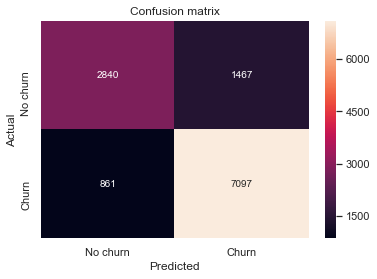

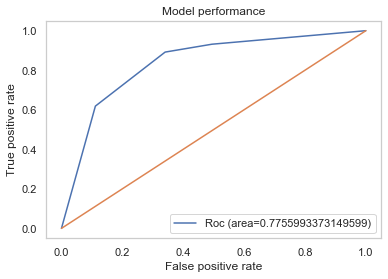

In [39]:
# Model 11: KNN with RFE
knn2= KNeighborsClassifier(3)
churn_prediction2(knn2,X2_train,X2_test,y2_train,y2_test) 

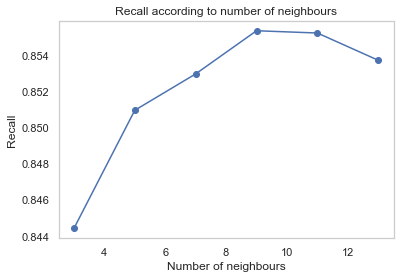

In [40]:
# KNN with PCA
best_neigh(X1_PCA,pca.transform(X1_test),y1_train,y1_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.74      0.77      0.75      4307
         1.0       0.87      0.86      0.86      7958

    accuracy                           0.82     12265
   macro avg       0.81      0.81      0.81     12265
weighted avg       0.83      0.82      0.82     12265

Accuracy   Score :  0.8236445169180595
Recall Score :  0.8553656697662729
Precision Score :  0.8705716843586137
Area under curve :  0.8101996679455931 



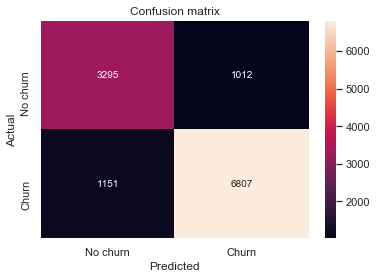

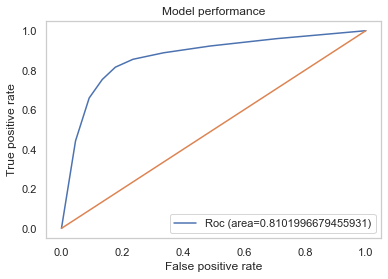

In [41]:
# Model 12 : KNN with PCA
knn3= KNeighborsClassifier(9)
churn_prediction2(knn3,X1_PCA,pca.transform(X1_test),y1_train,y1_test)

GaussianNB(priors=None, var_smoothing=1e-09)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.63      0.77      0.69      4307
         1.0       0.86      0.76      0.80      7958

    accuracy                           0.76     12265
   macro avg       0.74      0.76      0.75     12265
weighted avg       0.78      0.76      0.76     12265

Accuracy   Score :  0.7603750509580106
Recall Score :  0.7567227946720282
Precision Score :  0.8572241992882562
Area under curve :  0.7619230411716305 



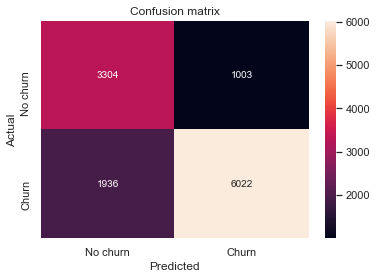

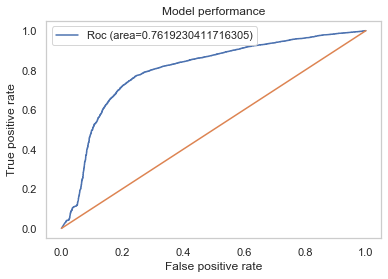

In [42]:
# Model 12 Naive Bayes without Feature Engineering
bayes = GaussianNB()
churn_prediction2(bayes,X1_train,X1_test,y1_train, y1_test) 

GaussianNB(priors=None, var_smoothing=1e-09)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.64      0.83      0.72      4307
         1.0       0.89      0.74      0.81      7958

    accuracy                           0.77     12265
   macro avg       0.76      0.79      0.77     12265
weighted avg       0.80      0.77      0.78     12265

Accuracy   Score :  0.774235629841011
Recall Score :  0.7446594621764262
Precision Score :  0.8893891640402222
Area under curve :  0.7867713377750021 



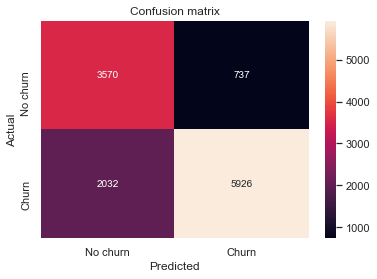

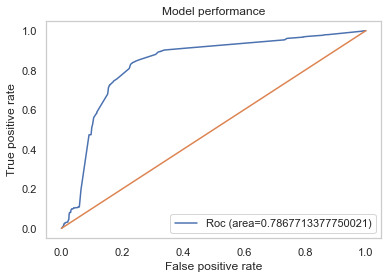

In [43]:
# Model 13 Naive Bayes with RFE
churn_prediction2(bayes,X2_train,X2_test,y2_train,y2_test)

GaussianNB(priors=None, var_smoothing=1e-09)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.71      0.76      0.73      4307
         1.0       0.86      0.83      0.85      7958

    accuracy                           0.81     12265
   macro avg       0.79      0.79      0.79     12265
weighted avg       0.81      0.81      0.81     12265

Accuracy   Score :  0.8057888300040766
Recall Score :  0.833123900477507
Precision Score :  0.8628318584070797
Area under curve :  0.79420299969313 



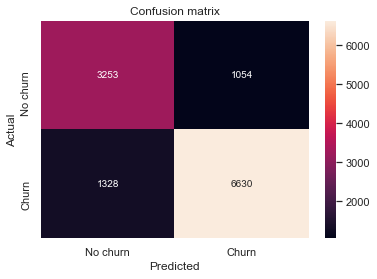

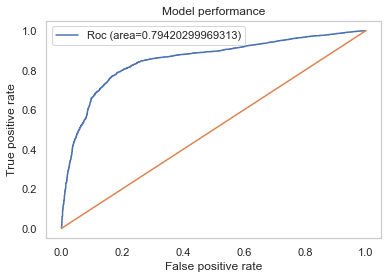

In [44]:
# Model 14 Naive Bayes with PCA
churn_prediction2(bayes,X1_PCA,pca.transform(X1_test),y1_train,y1_test)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.77      0.75      0.76      4307
         1.0       0.87      0.88      0.87      7958

    accuracy                           0.83     12265
   macro avg       0.82      0.81      0.82     12265
weighted avg       0.83      0.83      0.83     12265

Accuracy   Score :  0

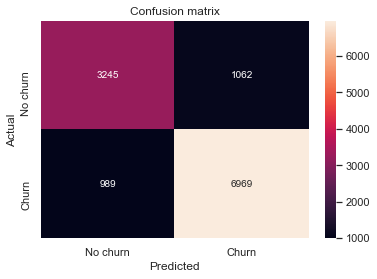

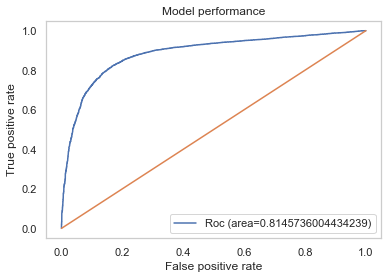

In [45]:
# Model 15 XGBoost without Feature Engineering
XGB = XGBClassifier()
churn_prediction2(XGB,X1_train,X1_test,y1_train, y1_test) 

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.78      0.72      0.75      4307
         1.0       0.85      0.89      0.87      7958

    accuracy                           0.83     12265
   macro avg       0.82      0.81      0.81     12265
weighted avg       0.83      0.83      0.83     12265

Accuracy   Score :  0

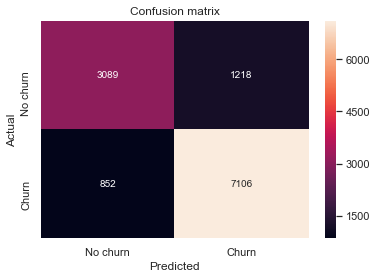

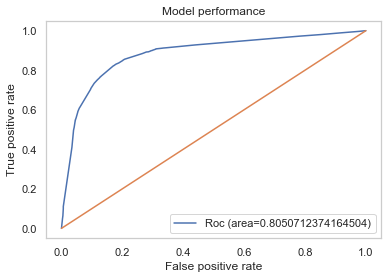

In [46]:
# Model 16 XGBoost with RFE
churn_prediction2(XGB,X2_train,X2_test,y2_train,y2_test)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.75      0.77      0.76      4307
         1.0       0.87      0.86      0.87      7958

    accuracy                           0.83     12265
   macro avg       0.81      0.82      0.81     12265
weighted avg       0.83      0.83      0.83     12265

Accuracy   Score :  0

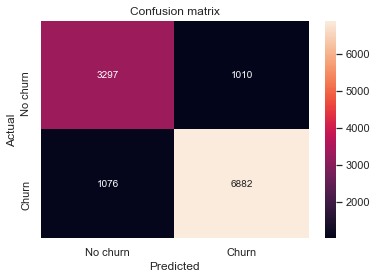

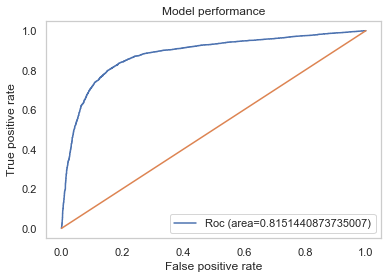

In [47]:
# Model 17 XGBoost with PCA
churn_prediction2(XGB,X1_PCA,pca.transform(X1_test),y1_train,y1_test)

Learning rate set to 0.043143
0:	learn: 0.6644481	total: 62.5ms	remaining: 1m 2s
1:	learn: 0.6359560	total: 71.6ms	remaining: 35.7s
2:	learn: 0.6129174	total: 80.9ms	remaining: 26.9s
3:	learn: 0.5899745	total: 90.3ms	remaining: 22.5s
4:	learn: 0.5695328	total: 99.4ms	remaining: 19.8s
5:	learn: 0.5529262	total: 109ms	remaining: 18.1s
6:	learn: 0.5367325	total: 118ms	remaining: 16.8s
7:	learn: 0.5232569	total: 127ms	remaining: 15.8s
8:	learn: 0.5098231	total: 135ms	remaining: 14.9s
9:	learn: 0.4979674	total: 144ms	remaining: 14.3s
10:	learn: 0.4884973	total: 154ms	remaining: 13.8s
11:	learn: 0.4808102	total: 163ms	remaining: 13.4s
12:	learn: 0.4731337	total: 172ms	remaining: 13.1s
13:	learn: 0.4671600	total: 181ms	remaining: 12.8s
14:	learn: 0.4607272	total: 197ms	remaining: 12.9s
15:	learn: 0.4549590	total: 207ms	remaining: 12.7s
16:	learn: 0.4494267	total: 216ms	remaining: 12.5s
17:	learn: 0.4436951	total: 225ms	remaining: 12.3s
18:	learn: 0.4393360	total: 235ms	remaining: 12.1s
19:	le

170:	learn: 0.3768189	total: 1.81s	remaining: 8.76s
171:	learn: 0.3767297	total: 1.82s	remaining: 8.75s
172:	learn: 0.3766754	total: 1.83s	remaining: 8.76s
173:	learn: 0.3766039	total: 1.84s	remaining: 8.74s
174:	learn: 0.3764963	total: 1.85s	remaining: 8.73s
175:	learn: 0.3764089	total: 1.86s	remaining: 8.73s
176:	learn: 0.3763548	total: 1.87s	remaining: 8.71s
177:	learn: 0.3763021	total: 1.88s	remaining: 8.7s
178:	learn: 0.3761946	total: 1.89s	remaining: 8.69s
179:	learn: 0.3761528	total: 1.9s	remaining: 8.67s
180:	learn: 0.3760746	total: 1.91s	remaining: 8.66s
181:	learn: 0.3760181	total: 1.92s	remaining: 8.64s
182:	learn: 0.3759601	total: 1.93s	remaining: 8.63s
183:	learn: 0.3759027	total: 1.94s	remaining: 8.62s
184:	learn: 0.3758247	total: 1.95s	remaining: 8.61s
185:	learn: 0.3757375	total: 1.96s	remaining: 8.59s
186:	learn: 0.3756364	total: 1.97s	remaining: 8.58s
187:	learn: 0.3755527	total: 1.98s	remaining: 8.56s
188:	learn: 0.3754825	total: 1.99s	remaining: 8.56s
189:	learn: 0.

330:	learn: 0.3646413	total: 3.43s	remaining: 6.93s
331:	learn: 0.3645853	total: 3.44s	remaining: 6.92s
332:	learn: 0.3645032	total: 3.45s	remaining: 6.91s
333:	learn: 0.3644460	total: 3.46s	remaining: 6.89s
334:	learn: 0.3643649	total: 3.47s	remaining: 6.88s
335:	learn: 0.3642565	total: 3.48s	remaining: 6.87s
336:	learn: 0.3641811	total: 3.49s	remaining: 6.86s
337:	learn: 0.3641119	total: 3.5s	remaining: 6.85s
338:	learn: 0.3640319	total: 3.51s	remaining: 6.84s
339:	learn: 0.3639860	total: 3.52s	remaining: 6.82s
340:	learn: 0.3639035	total: 3.52s	remaining: 6.81s
341:	learn: 0.3638235	total: 3.54s	remaining: 6.8s
342:	learn: 0.3637383	total: 3.55s	remaining: 6.79s
343:	learn: 0.3636488	total: 3.56s	remaining: 6.78s
344:	learn: 0.3635824	total: 3.56s	remaining: 6.77s
345:	learn: 0.3635065	total: 3.57s	remaining: 6.75s
346:	learn: 0.3634301	total: 3.58s	remaining: 6.74s
347:	learn: 0.3633803	total: 3.59s	remaining: 6.73s
348:	learn: 0.3633394	total: 3.6s	remaining: 6.72s
349:	learn: 0.3

495:	learn: 0.3542003	total: 5.05s	remaining: 5.13s
496:	learn: 0.3541458	total: 5.06s	remaining: 5.12s
497:	learn: 0.3540964	total: 5.07s	remaining: 5.11s
498:	learn: 0.3540238	total: 5.08s	remaining: 5.1s
499:	learn: 0.3539821	total: 5.09s	remaining: 5.09s
500:	learn: 0.3539599	total: 5.11s	remaining: 5.08s
501:	learn: 0.3538789	total: 5.12s	remaining: 5.07s
502:	learn: 0.3537928	total: 5.13s	remaining: 5.06s
503:	learn: 0.3537470	total: 5.13s	remaining: 5.05s
504:	learn: 0.3536718	total: 5.14s	remaining: 5.04s
505:	learn: 0.3536168	total: 5.16s	remaining: 5.03s
506:	learn: 0.3535605	total: 5.17s	remaining: 5.02s
507:	learn: 0.3534849	total: 5.17s	remaining: 5.01s
508:	learn: 0.3534351	total: 5.18s	remaining: 5s
509:	learn: 0.3533830	total: 5.2s	remaining: 4.99s
510:	learn: 0.3533171	total: 5.21s	remaining: 4.98s
511:	learn: 0.3532425	total: 5.22s	remaining: 4.97s
512:	learn: 0.3531820	total: 5.23s	remaining: 4.96s
513:	learn: 0.3531416	total: 5.24s	remaining: 4.95s
514:	learn: 0.353

659:	learn: 0.3445402	total: 6.87s	remaining: 3.54s
660:	learn: 0.3444813	total: 6.88s	remaining: 3.53s
661:	learn: 0.3444243	total: 6.89s	remaining: 3.52s
662:	learn: 0.3443804	total: 6.9s	remaining: 3.51s
663:	learn: 0.3443238	total: 6.91s	remaining: 3.5s
664:	learn: 0.3443011	total: 6.92s	remaining: 3.48s
665:	learn: 0.3442569	total: 6.93s	remaining: 3.48s
666:	learn: 0.3442096	total: 6.94s	remaining: 3.47s
667:	learn: 0.3441591	total: 6.95s	remaining: 3.46s
668:	learn: 0.3440974	total: 6.96s	remaining: 3.44s
669:	learn: 0.3440566	total: 6.97s	remaining: 3.44s
670:	learn: 0.3439990	total: 6.98s	remaining: 3.42s
671:	learn: 0.3439258	total: 6.99s	remaining: 3.41s
672:	learn: 0.3438513	total: 7.01s	remaining: 3.4s
673:	learn: 0.3437845	total: 7.02s	remaining: 3.39s
674:	learn: 0.3437325	total: 7.03s	remaining: 3.38s
675:	learn: 0.3437017	total: 7.04s	remaining: 3.37s
676:	learn: 0.3436566	total: 7.05s	remaining: 3.36s
677:	learn: 0.3436004	total: 7.06s	remaining: 3.35s
678:	learn: 0.3

822:	learn: 0.3360118	total: 8.5s	remaining: 1.83s
823:	learn: 0.3359592	total: 8.52s	remaining: 1.82s
824:	learn: 0.3359031	total: 8.53s	remaining: 1.81s
825:	learn: 0.3358530	total: 8.54s	remaining: 1.8s
826:	learn: 0.3357954	total: 8.54s	remaining: 1.79s
827:	learn: 0.3357650	total: 8.55s	remaining: 1.78s
828:	learn: 0.3357369	total: 8.56s	remaining: 1.77s
829:	learn: 0.3356607	total: 8.57s	remaining: 1.76s
830:	learn: 0.3356166	total: 8.59s	remaining: 1.75s
831:	learn: 0.3355757	total: 8.59s	remaining: 1.74s
832:	learn: 0.3355422	total: 8.6s	remaining: 1.73s
833:	learn: 0.3355011	total: 8.62s	remaining: 1.72s
834:	learn: 0.3354646	total: 8.63s	remaining: 1.7s
835:	learn: 0.3354388	total: 8.64s	remaining: 1.69s
836:	learn: 0.3353680	total: 8.65s	remaining: 1.68s
837:	learn: 0.3353260	total: 8.66s	remaining: 1.67s
838:	learn: 0.3352711	total: 8.67s	remaining: 1.66s
839:	learn: 0.3352229	total: 8.68s	remaining: 1.65s
840:	learn: 0.3351816	total: 8.69s	remaining: 1.64s
841:	learn: 0.33

998:	learn: 0.3274203	total: 10.3s	remaining: 10.3ms
999:	learn: 0.3273738	total: 10.3s	remaining: 0us

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.77      0.75      0.76      4307
         1.0       0.87      0.88      0.87      7958

    accuracy                           0.84     12265
   macro avg       0.82      0.82      0.82     12265
weighted avg       0.84      0.84      0.84     12265

Accuracy   Score :  0.8366082348145129
Recall Score :  0.8812515707464187
Precision Score :  0.8688057482656095
Area under curve :  0.8176863843980526 



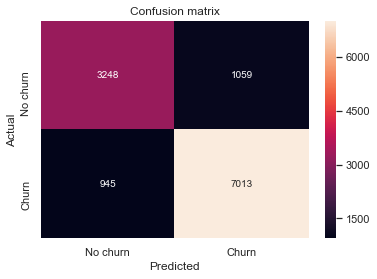

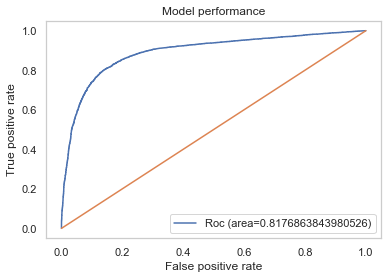

In [48]:
# Model 18 CatBoost without Feature engineering
cat = CatBoostClassifier()
churn_prediction2(cat,X1_train,X1_test,y1_train, y1_test) 

Learning rate set to 0.043143
0:	learn: 0.6618764	total: 9.4ms	remaining: 9.39s
1:	learn: 0.6340524	total: 16.8ms	remaining: 8.37s
2:	learn: 0.6088591	total: 25.3ms	remaining: 8.42s
3:	learn: 0.5885341	total: 32.3ms	remaining: 8.03s
4:	learn: 0.5684813	total: 40.9ms	remaining: 8.13s
5:	learn: 0.5522532	total: 46.4ms	remaining: 7.69s
6:	learn: 0.5360629	total: 53.6ms	remaining: 7.6s
7:	learn: 0.5230362	total: 62ms	remaining: 7.68s
8:	learn: 0.5114640	total: 68.6ms	remaining: 7.55s
9:	learn: 0.4995914	total: 78.4ms	remaining: 7.76s
10:	learn: 0.4891249	total: 87.8ms	remaining: 7.89s
11:	learn: 0.4807333	total: 98.2ms	remaining: 8.08s
12:	learn: 0.4721899	total: 107ms	remaining: 8.11s
13:	learn: 0.4645960	total: 115ms	remaining: 8.12s
14:	learn: 0.4586582	total: 121ms	remaining: 7.92s
15:	learn: 0.4523730	total: 129ms	remaining: 7.93s
16:	learn: 0.4467667	total: 138ms	remaining: 7.95s
17:	learn: 0.4427755	total: 144ms	remaining: 7.87s
18:	learn: 0.4392477	total: 150ms	remaining: 7.75s
19:

180:	learn: 0.3933686	total: 1.45s	remaining: 6.54s
181:	learn: 0.3933601	total: 1.46s	remaining: 6.54s
182:	learn: 0.3933509	total: 1.47s	remaining: 6.54s
183:	learn: 0.3933362	total: 1.47s	remaining: 6.53s
184:	learn: 0.3933286	total: 1.48s	remaining: 6.53s
185:	learn: 0.3933248	total: 1.49s	remaining: 6.51s
186:	learn: 0.3933193	total: 1.5s	remaining: 6.51s
187:	learn: 0.3933133	total: 1.5s	remaining: 6.5s
188:	learn: 0.3933062	total: 1.51s	remaining: 6.49s
189:	learn: 0.3932917	total: 1.52s	remaining: 6.48s
190:	learn: 0.3932816	total: 1.53s	remaining: 6.48s
191:	learn: 0.3932697	total: 1.54s	remaining: 6.47s
192:	learn: 0.3932594	total: 1.54s	remaining: 6.46s
193:	learn: 0.3932450	total: 1.55s	remaining: 6.46s
194:	learn: 0.3932391	total: 1.56s	remaining: 6.45s
195:	learn: 0.3932377	total: 1.57s	remaining: 6.43s
196:	learn: 0.3932312	total: 1.58s	remaining: 6.43s
197:	learn: 0.3932169	total: 1.58s	remaining: 6.42s
198:	learn: 0.3932086	total: 1.59s	remaining: 6.42s
199:	learn: 0.3

347:	learn: 0.3922751	total: 2.88s	remaining: 5.4s
348:	learn: 0.3922712	total: 2.89s	remaining: 5.39s
349:	learn: 0.3922665	total: 2.9s	remaining: 5.39s
350:	learn: 0.3922619	total: 2.91s	remaining: 5.38s
351:	learn: 0.3922586	total: 2.92s	remaining: 5.38s
352:	learn: 0.3922543	total: 2.93s	remaining: 5.37s
353:	learn: 0.3922495	total: 2.94s	remaining: 5.36s
354:	learn: 0.3922471	total: 2.95s	remaining: 5.35s
355:	learn: 0.3922445	total: 2.95s	remaining: 5.34s
356:	learn: 0.3922405	total: 2.96s	remaining: 5.34s
357:	learn: 0.3922370	total: 2.97s	remaining: 5.33s
358:	learn: 0.3922338	total: 2.98s	remaining: 5.32s
359:	learn: 0.3922314	total: 2.99s	remaining: 5.31s
360:	learn: 0.3922267	total: 3s	remaining: 5.3s
361:	learn: 0.3922221	total: 3s	remaining: 5.29s
362:	learn: 0.3922179	total: 3.01s	remaining: 5.29s
363:	learn: 0.3922134	total: 3.02s	remaining: 5.28s
364:	learn: 0.3922090	total: 3.03s	remaining: 5.27s
365:	learn: 0.3922054	total: 3.04s	remaining: 5.26s
366:	learn: 0.3922012

513:	learn: 0.3918213	total: 4.32s	remaining: 4.08s
514:	learn: 0.3918185	total: 4.32s	remaining: 4.07s
515:	learn: 0.3918161	total: 4.33s	remaining: 4.06s
516:	learn: 0.3918140	total: 4.34s	remaining: 4.06s
517:	learn: 0.3918114	total: 4.35s	remaining: 4.05s
518:	learn: 0.3918095	total: 4.36s	remaining: 4.04s
519:	learn: 0.3918068	total: 4.37s	remaining: 4.03s
520:	learn: 0.3918050	total: 4.38s	remaining: 4.03s
521:	learn: 0.3918033	total: 4.39s	remaining: 4.02s
522:	learn: 0.3918012	total: 4.4s	remaining: 4.01s
523:	learn: 0.3918001	total: 4.41s	remaining: 4s
524:	learn: 0.3917981	total: 4.42s	remaining: 3.99s
525:	learn: 0.3917957	total: 4.42s	remaining: 3.99s
526:	learn: 0.3917922	total: 4.43s	remaining: 3.98s
527:	learn: 0.3917901	total: 4.44s	remaining: 3.97s
528:	learn: 0.3917896	total: 4.45s	remaining: 3.96s
529:	learn: 0.3917885	total: 4.46s	remaining: 3.95s
530:	learn: 0.3917870	total: 4.47s	remaining: 3.95s
531:	learn: 0.3917849	total: 4.48s	remaining: 3.94s
532:	learn: 0.39

672:	learn: 0.3915856	total: 5.75s	remaining: 2.79s
673:	learn: 0.3915845	total: 5.76s	remaining: 2.79s
674:	learn: 0.3915834	total: 5.77s	remaining: 2.78s
675:	learn: 0.3915825	total: 5.78s	remaining: 2.77s
676:	learn: 0.3915813	total: 5.79s	remaining: 2.76s
677:	learn: 0.3915803	total: 5.79s	remaining: 2.75s
678:	learn: 0.3915795	total: 5.8s	remaining: 2.74s
679:	learn: 0.3915783	total: 5.81s	remaining: 2.73s
680:	learn: 0.3915773	total: 5.82s	remaining: 2.73s
681:	learn: 0.3915765	total: 5.83s	remaining: 2.72s
682:	learn: 0.3915759	total: 5.84s	remaining: 2.71s
683:	learn: 0.3915756	total: 5.84s	remaining: 2.7s
684:	learn: 0.3915746	total: 5.85s	remaining: 2.69s
685:	learn: 0.3915740	total: 5.86s	remaining: 2.68s
686:	learn: 0.3915732	total: 5.87s	remaining: 2.67s
687:	learn: 0.3915724	total: 5.88s	remaining: 2.67s
688:	learn: 0.3915712	total: 5.88s	remaining: 2.66s
689:	learn: 0.3915702	total: 5.89s	remaining: 2.65s
690:	learn: 0.3915692	total: 5.9s	remaining: 2.64s
691:	learn: 0.3

842:	learn: 0.3914543	total: 7.2s	remaining: 1.34s
843:	learn: 0.3914537	total: 7.2s	remaining: 1.33s
844:	learn: 0.3914532	total: 7.21s	remaining: 1.32s
845:	learn: 0.3914526	total: 7.22s	remaining: 1.31s
846:	learn: 0.3914522	total: 7.22s	remaining: 1.3s
847:	learn: 0.3914514	total: 7.23s	remaining: 1.3s
848:	learn: 0.3914509	total: 7.24s	remaining: 1.29s
849:	learn: 0.3914504	total: 7.25s	remaining: 1.28s
850:	learn: 0.3914500	total: 7.25s	remaining: 1.27s
851:	learn: 0.3914495	total: 7.26s	remaining: 1.26s
852:	learn: 0.3914488	total: 7.27s	remaining: 1.25s
853:	learn: 0.3914485	total: 7.28s	remaining: 1.24s
854:	learn: 0.3914480	total: 7.29s	remaining: 1.24s
855:	learn: 0.3914475	total: 7.29s	remaining: 1.23s
856:	learn: 0.3914472	total: 7.3s	remaining: 1.22s
857:	learn: 0.3914467	total: 7.31s	remaining: 1.21s
858:	learn: 0.3914459	total: 7.32s	remaining: 1.2s
859:	learn: 0.3914453	total: 7.33s	remaining: 1.19s
860:	learn: 0.3914440	total: 7.34s	remaining: 1.18s
861:	learn: 0.3914


 Classification report : 
               precision    recall  f1-score   support

         0.0       0.78      0.72      0.75      4307
         1.0       0.85      0.89      0.87      7958

    accuracy                           0.83     12265
   macro avg       0.82      0.80      0.81     12265
weighted avg       0.83      0.83      0.83     12265

Accuracy   Score :  0.8307378719934774
Recall Score :  0.8923096255340538
Precision Score :  0.8534855769230769
Area under curve :  0.804640998046804 



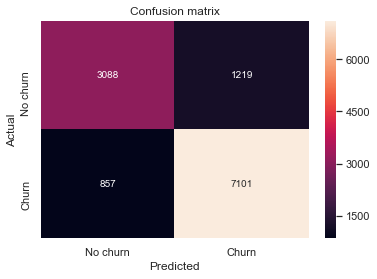

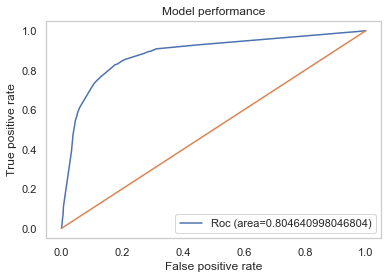

In [49]:
# Model 19 CatBoost with RFE
churn_prediction2(cat,X2_train,X2_test,y2_train,y2_test)

Learning rate set to 0.043143
0:	learn: 0.6671708	total: 16.4ms	remaining: 16.4s
1:	learn: 0.6436834	total: 25.7ms	remaining: 12.8s
2:	learn: 0.6223252	total: 37.8ms	remaining: 12.5s
3:	learn: 0.6033798	total: 48.6ms	remaining: 12.1s
4:	learn: 0.5857287	total: 59.3ms	remaining: 11.8s
5:	learn: 0.5700231	total: 69.6ms	remaining: 11.5s
6:	learn: 0.5557123	total: 98.2ms	remaining: 13.9s
7:	learn: 0.5430371	total: 108ms	remaining: 13.4s
8:	learn: 0.5322181	total: 117ms	remaining: 12.9s
9:	learn: 0.5216041	total: 134ms	remaining: 13.3s
10:	learn: 0.5124822	total: 145ms	remaining: 13.1s
11:	learn: 0.5049541	total: 155ms	remaining: 12.8s
12:	learn: 0.4970617	total: 167ms	remaining: 12.7s
13:	learn: 0.4908279	total: 177ms	remaining: 12.5s
14:	learn: 0.4844763	total: 188ms	remaining: 12.4s
15:	learn: 0.4788718	total: 204ms	remaining: 12.5s
16:	learn: 0.4744754	total: 214ms	remaining: 12.4s
17:	learn: 0.4692945	total: 225ms	remaining: 12.3s
18:	learn: 0.4645734	total: 245ms	remaining: 12.6s
19:	

173:	learn: 0.3838139	total: 2s	remaining: 9.49s
174:	learn: 0.3837070	total: 2.01s	remaining: 9.47s
175:	learn: 0.3835900	total: 2.02s	remaining: 9.46s
176:	learn: 0.3834715	total: 2.03s	remaining: 9.44s
177:	learn: 0.3833564	total: 2.04s	remaining: 9.42s
178:	learn: 0.3832623	total: 2.05s	remaining: 9.4s
179:	learn: 0.3831702	total: 2.06s	remaining: 9.39s
180:	learn: 0.3830733	total: 2.07s	remaining: 9.38s
181:	learn: 0.3829532	total: 2.08s	remaining: 9.37s
182:	learn: 0.3828441	total: 2.1s	remaining: 9.38s
183:	learn: 0.3827285	total: 2.11s	remaining: 9.36s
184:	learn: 0.3826152	total: 2.12s	remaining: 9.35s
185:	learn: 0.3825402	total: 2.13s	remaining: 9.33s
186:	learn: 0.3824396	total: 2.14s	remaining: 9.32s
187:	learn: 0.3823225	total: 2.15s	remaining: 9.3s
188:	learn: 0.3822111	total: 2.17s	remaining: 9.29s
189:	learn: 0.3821284	total: 2.18s	remaining: 9.28s
190:	learn: 0.3820181	total: 2.19s	remaining: 9.27s
191:	learn: 0.3819063	total: 2.2s	remaining: 9.26s
192:	learn: 0.38182

345:	learn: 0.3667664	total: 3.81s	remaining: 7.21s
346:	learn: 0.3666735	total: 3.83s	remaining: 7.21s
347:	learn: 0.3666036	total: 3.84s	remaining: 7.2s
348:	learn: 0.3665100	total: 3.85s	remaining: 7.18s
349:	learn: 0.3664208	total: 3.86s	remaining: 7.17s
350:	learn: 0.3662956	total: 3.87s	remaining: 7.16s
351:	learn: 0.3662258	total: 3.88s	remaining: 7.14s
352:	learn: 0.3661447	total: 3.89s	remaining: 7.13s
353:	learn: 0.3660452	total: 3.9s	remaining: 7.12s
354:	learn: 0.3659553	total: 3.91s	remaining: 7.1s
355:	learn: 0.3658582	total: 3.92s	remaining: 7.09s
356:	learn: 0.3657640	total: 3.93s	remaining: 7.08s
357:	learn: 0.3656710	total: 3.94s	remaining: 7.06s
358:	learn: 0.3655904	total: 3.95s	remaining: 7.05s
359:	learn: 0.3654692	total: 3.96s	remaining: 7.04s
360:	learn: 0.3653601	total: 3.97s	remaining: 7.02s
361:	learn: 0.3652695	total: 3.98s	remaining: 7.01s
362:	learn: 0.3652056	total: 3.99s	remaining: 7s
363:	learn: 0.3650832	total: 4s	remaining: 7s
364:	learn: 0.3649952	to

506:	learn: 0.3531689	total: 5.45s	remaining: 5.3s
507:	learn: 0.3530928	total: 5.46s	remaining: 5.29s
508:	learn: 0.3530184	total: 5.47s	remaining: 5.28s
509:	learn: 0.3529422	total: 5.48s	remaining: 5.27s
510:	learn: 0.3528750	total: 5.49s	remaining: 5.26s
511:	learn: 0.3528031	total: 5.5s	remaining: 5.25s
512:	learn: 0.3527272	total: 5.51s	remaining: 5.24s
513:	learn: 0.3526605	total: 5.53s	remaining: 5.22s
514:	learn: 0.3525775	total: 5.54s	remaining: 5.21s
515:	learn: 0.3524702	total: 5.55s	remaining: 5.2s
516:	learn: 0.3524259	total: 5.56s	remaining: 5.19s
517:	learn: 0.3523491	total: 5.57s	remaining: 5.18s
518:	learn: 0.3522585	total: 5.58s	remaining: 5.17s
519:	learn: 0.3521516	total: 5.59s	remaining: 5.16s
520:	learn: 0.3520843	total: 5.6s	remaining: 5.15s
521:	learn: 0.3519746	total: 5.61s	remaining: 5.14s
522:	learn: 0.3519118	total: 5.62s	remaining: 5.12s
523:	learn: 0.3518469	total: 5.63s	remaining: 5.11s
524:	learn: 0.3517436	total: 5.64s	remaining: 5.1s
525:	learn: 0.351

676:	learn: 0.3404499	total: 7.26s	remaining: 3.46s
677:	learn: 0.3403992	total: 7.27s	remaining: 3.45s
678:	learn: 0.3403200	total: 7.28s	remaining: 3.44s
679:	learn: 0.3402154	total: 7.29s	remaining: 3.43s
680:	learn: 0.3401550	total: 7.3s	remaining: 3.42s
681:	learn: 0.3400987	total: 7.31s	remaining: 3.41s
682:	learn: 0.3400454	total: 7.32s	remaining: 3.4s
683:	learn: 0.3400050	total: 7.33s	remaining: 3.39s
684:	learn: 0.3399280	total: 7.34s	remaining: 3.38s
685:	learn: 0.3398625	total: 7.35s	remaining: 3.37s
686:	learn: 0.3397674	total: 7.36s	remaining: 3.35s
687:	learn: 0.3396651	total: 7.38s	remaining: 3.34s
688:	learn: 0.3395974	total: 7.38s	remaining: 3.33s
689:	learn: 0.3395399	total: 7.4s	remaining: 3.32s
690:	learn: 0.3394803	total: 7.41s	remaining: 3.31s
691:	learn: 0.3393988	total: 7.42s	remaining: 3.3s
692:	learn: 0.3393416	total: 7.43s	remaining: 3.29s
693:	learn: 0.3392637	total: 7.44s	remaining: 3.28s
694:	learn: 0.3391920	total: 7.45s	remaining: 3.27s
695:	learn: 0.33

839:	learn: 0.3295298	total: 9.07s	remaining: 1.73s
840:	learn: 0.3294841	total: 9.08s	remaining: 1.72s
841:	learn: 0.3294444	total: 9.09s	remaining: 1.71s
842:	learn: 0.3293933	total: 9.1s	remaining: 1.69s
843:	learn: 0.3293188	total: 9.11s	remaining: 1.68s
844:	learn: 0.3292795	total: 9.12s	remaining: 1.67s
845:	learn: 0.3292251	total: 9.13s	remaining: 1.66s
846:	learn: 0.3291473	total: 9.14s	remaining: 1.65s
847:	learn: 0.3290818	total: 9.15s	remaining: 1.64s
848:	learn: 0.3290207	total: 9.16s	remaining: 1.63s
849:	learn: 0.3289663	total: 9.17s	remaining: 1.62s
850:	learn: 0.3288835	total: 9.19s	remaining: 1.61s
851:	learn: 0.3288348	total: 9.2s	remaining: 1.6s
852:	learn: 0.3287647	total: 9.21s	remaining: 1.59s
853:	learn: 0.3286937	total: 9.22s	remaining: 1.57s
854:	learn: 0.3286033	total: 9.23s	remaining: 1.56s
855:	learn: 0.3285099	total: 9.24s	remaining: 1.55s
856:	learn: 0.3284449	total: 9.25s	remaining: 1.54s
857:	learn: 0.3283836	total: 9.26s	remaining: 1.53s
858:	learn: 0.3


 Classification report : 
               precision    recall  f1-score   support

         0.0       0.76      0.77      0.76      4307
         1.0       0.87      0.87      0.87      7958

    accuracy                           0.83     12265
   macro avg       0.82      0.82      0.82     12265
weighted avg       0.83      0.83      0.83     12265

Accuracy   Score :  0.831879331430901
Recall Score :  0.866423724553908
Precision Score :  0.8734481884975931
Area under curve :  0.8172378664561971 



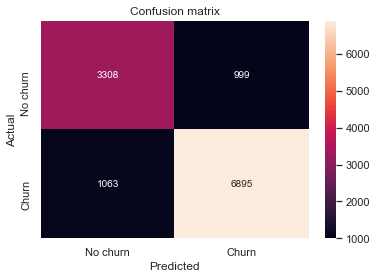

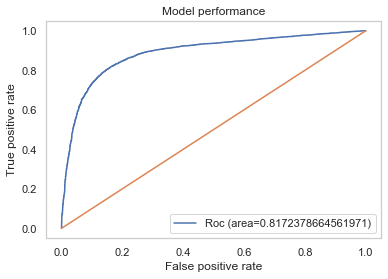

In [50]:
# Model 20 CatBoost with PCA
churn_prediction2(cat,X1_PCA,pca.transform(X1_test),y1_train,y1_test)

# Hyper-parameter tuning

In [51]:
# Tuning of KNN with RFE
model = KNeighborsClassifier()
params= {'n_neighbors': range(2,21,2), 'weights':['uniform', 'distance'], \
         'metric' :  ['manhattan', 'minkowski']}

cv= RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
grid_search = GridSearchCV(estimator = model, param_grid=params, n_jobs=-1, scoring ='recall', cv=cv)
grid_result=grid_search.fit(X1,y)
print(f'Best {grid_result.best_score_} using {grid_result.best_params_}')

Best 0.86395594635933 using {'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'uniform'}


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.75      0.78      0.77      4307
         1.0       0.88      0.86      0.87      7958

    accuracy                           0.83     12265
   macro avg       0.81      0.82      0.82     12265
weighted avg       0.83      0.83      0.83     12265

Accuracy   Score :  0.8317977986139421
Recall Score :  0.8586328223171651
Precision Score :  0.8792948140522455
Area under curve :  0.8204239105781321 



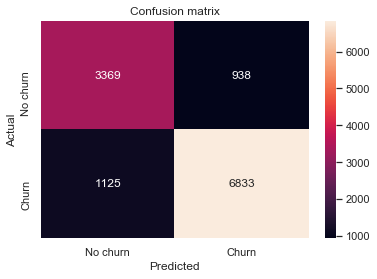

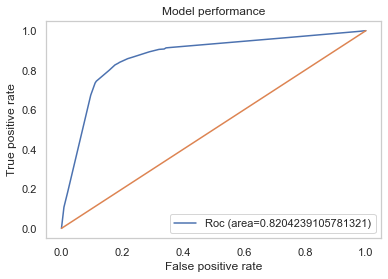

In [25]:
model1=KNeighborsClassifier(n_neighbors=20, metric = 'manhattan', weights = 'uniform')
churn_prediction2(model1,X2_train,X2_test,y2_train, y2_test)

In [12]:
# Tuning of Catboost classifier with RFE
model=CatBoostClassifier()
params = {'depth':[3,6,9],\
          'iterations':[250,500,1000],\
          'learning_rate':[0.03,0.001,0.01,0.1, 0.3],\
          'l2_leaf_reg':[3,1,5,10,100]}

cv= RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=42)
grid_search = GridSearchCV(estimator = model, param_grid=params, n_jobs=-1, scoring ='recall', cv=cv)
grid_result=grid_search.fit(X1,y)
print(f'Best {grid_result.best_score_} using {grid_result.best_params_}')

0:	learn: 0.6924619	total: 73.8ms	remaining: 18.4s
1:	learn: 0.6917234	total: 84.4ms	remaining: 10.5s
2:	learn: 0.6910414	total: 92.9ms	remaining: 7.64s
3:	learn: 0.6903065	total: 101ms	remaining: 6.23s
4:	learn: 0.6896262	total: 109ms	remaining: 5.36s
5:	learn: 0.6889492	total: 116ms	remaining: 4.73s
6:	learn: 0.6882739	total: 123ms	remaining: 4.27s
7:	learn: 0.6875457	total: 130ms	remaining: 3.92s
8:	learn: 0.6868193	total: 137ms	remaining: 3.66s
9:	learn: 0.6860948	total: 143ms	remaining: 3.44s
10:	learn: 0.6854261	total: 150ms	remaining: 3.26s
11:	learn: 0.6847051	total: 157ms	remaining: 3.11s
12:	learn: 0.6840397	total: 164ms	remaining: 2.98s
13:	learn: 0.6833795	total: 170ms	remaining: 2.87s
14:	learn: 0.6827155	total: 177ms	remaining: 2.77s
15:	learn: 0.6821137	total: 183ms	remaining: 2.68s
16:	learn: 0.6814596	total: 190ms	remaining: 2.61s
17:	learn: 0.6808019	total: 197ms	remaining: 2.54s
18:	learn: 0.6801458	total: 204ms	remaining: 2.48s
19:	learn: 0.6794912	total: 211ms	rema

170:	learn: 0.5941973	total: 1.35s	remaining: 624ms
171:	learn: 0.5937472	total: 1.36s	remaining: 616ms
172:	learn: 0.5932982	total: 1.37s	remaining: 609ms
173:	learn: 0.5928504	total: 1.38s	remaining: 601ms
174:	learn: 0.5923629	total: 1.39s	remaining: 594ms
175:	learn: 0.5918767	total: 1.39s	remaining: 586ms
176:	learn: 0.5913894	total: 1.4s	remaining: 578ms
177:	learn: 0.5909057	total: 1.41s	remaining: 570ms
178:	learn: 0.5904233	total: 1.42s	remaining: 563ms
179:	learn: 0.5900280	total: 1.43s	remaining: 555ms
180:	learn: 0.5895879	total: 1.43s	remaining: 547ms
181:	learn: 0.5891088	total: 1.44s	remaining: 539ms
182:	learn: 0.5886310	total: 1.45s	remaining: 531ms
183:	learn: 0.5881545	total: 1.46s	remaining: 522ms
184:	learn: 0.5876791	total: 1.46s	remaining: 514ms
185:	learn: 0.5872051	total: 1.47s	remaining: 506ms
186:	learn: 0.5867691	total: 1.48s	remaining: 498ms
187:	learn: 0.5862977	total: 1.49s	remaining: 490ms
188:	learn: 0.5858274	total: 1.49s	remaining: 482ms
189:	learn: 0

0:	learn: 0.6922593	total: 7.4ms	remaining: 1.84s
1:	learn: 0.6914595	total: 13.5ms	remaining: 1.67s
2:	learn: 0.6905533	total: 20.8ms	remaining: 1.71s
3:	learn: 0.6896734	total: 26.8ms	remaining: 1.65s
4:	learn: 0.6888023	total: 32.5ms	remaining: 1.59s
5:	learn: 0.6878572	total: 38.2ms	remaining: 1.55s
6:	learn: 0.6869919	total: 43.9ms	remaining: 1.52s
7:	learn: 0.6862062	total: 49.3ms	remaining: 1.49s
8:	learn: 0.6853455	total: 55.7ms	remaining: 1.49s
9:	learn: 0.6844116	total: 61.3ms	remaining: 1.47s
10:	learn: 0.6835506	total: 67.1ms	remaining: 1.46s
11:	learn: 0.6826224	total: 72.8ms	remaining: 1.44s
12:	learn: 0.6817669	total: 78.6ms	remaining: 1.43s
13:	learn: 0.6808671	total: 83.8ms	remaining: 1.41s
14:	learn: 0.6800981	total: 90.7ms	remaining: 1.42s
15:	learn: 0.6793247	total: 95.9ms	remaining: 1.4s
16:	learn: 0.6784792	total: 102ms	remaining: 1.4s
17:	learn: 0.6777179	total: 108ms	remaining: 1.39s
18:	learn: 0.6768774	total: 114ms	remaining: 1.38s
19:	learn: 0.6760396	total: 

179:	learn: 0.5684879	total: 1.07s	remaining: 415ms
180:	learn: 0.5680329	total: 1.07s	remaining: 409ms
181:	learn: 0.5674810	total: 1.08s	remaining: 404ms
182:	learn: 0.5669337	total: 1.09s	remaining: 398ms
183:	learn: 0.5664903	total: 1.09s	remaining: 392ms
184:	learn: 0.5659986	total: 1.1s	remaining: 387ms
185:	learn: 0.5655081	total: 1.11s	remaining: 381ms
186:	learn: 0.5649673	total: 1.11s	remaining: 375ms
187:	learn: 0.5644720	total: 1.12s	remaining: 369ms
188:	learn: 0.5639347	total: 1.12s	remaining: 363ms
189:	learn: 0.5633992	total: 1.13s	remaining: 357ms
190:	learn: 0.5629170	total: 1.14s	remaining: 351ms
191:	learn: 0.5623849	total: 1.14s	remaining: 345ms
192:	learn: 0.5619025	total: 1.15s	remaining: 339ms
193:	learn: 0.5614663	total: 1.15s	remaining: 333ms
194:	learn: 0.5610383	total: 1.16s	remaining: 327ms
195:	learn: 0.5606403	total: 1.17s	remaining: 321ms
196:	learn: 0.5601157	total: 1.17s	remaining: 315ms
197:	learn: 0.5595929	total: 1.18s	remaining: 309ms
198:	learn: 0

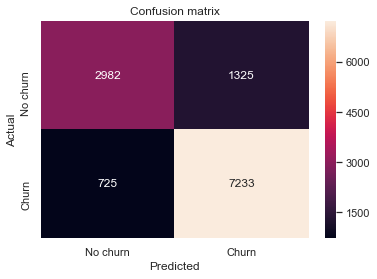

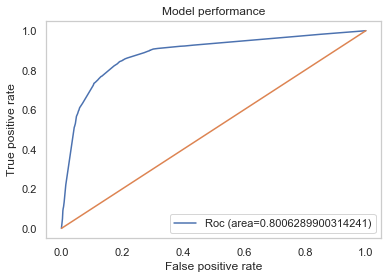

In [26]:
model2= CatBoostClassifier(depth= 3, iterations= 250, l2_leaf_reg= 3, learning_rate= 0.0013)
churn_prediction2(model2,X2_train,X2_test,y2_train, y2_test)

# Ensemble

In [27]:
# V1 : Logistic Regression + Catboost
estimators = [('neigh', model1), ('cat', model2)]
ensemble = VotingClassifier(estimators, voting='hard')

In [28]:
model3= ensemble.fit(X2_train, y2_train)
y_pred3 = model3.predict(X2_test)

0:	learn: 0.6922593	total: 5.95ms	remaining: 1.48s
1:	learn: 0.6914595	total: 11.8ms	remaining: 1.46s
2:	learn: 0.6905533	total: 18.8ms	remaining: 1.54s
3:	learn: 0.6896734	total: 24.7ms	remaining: 1.52s
4:	learn: 0.6888023	total: 30.1ms	remaining: 1.47s
5:	learn: 0.6878572	total: 35.6ms	remaining: 1.45s
6:	learn: 0.6869919	total: 41.3ms	remaining: 1.43s
7:	learn: 0.6862062	total: 46.5ms	remaining: 1.41s
8:	learn: 0.6853455	total: 52.5ms	remaining: 1.4s
9:	learn: 0.6844116	total: 58.2ms	remaining: 1.4s
10:	learn: 0.6835506	total: 63.6ms	remaining: 1.38s
11:	learn: 0.6826224	total: 69.2ms	remaining: 1.37s
12:	learn: 0.6817669	total: 75.1ms	remaining: 1.37s
13:	learn: 0.6808671	total: 80.2ms	remaining: 1.35s
14:	learn: 0.6800981	total: 86.9ms	remaining: 1.36s
15:	learn: 0.6793247	total: 92.2ms	remaining: 1.35s
16:	learn: 0.6784792	total: 97.8ms	remaining: 1.34s
17:	learn: 0.6777179	total: 104ms	remaining: 1.34s
18:	learn: 0.6768774	total: 110ms	remaining: 1.33s
19:	learn: 0.6760396	total

177:	learn: 0.5695450	total: 1.06s	remaining: 431ms
178:	learn: 0.5689908	total: 1.08s	remaining: 428ms
179:	learn: 0.5684879	total: 1.08s	remaining: 422ms
180:	learn: 0.5680329	total: 1.09s	remaining: 415ms
181:	learn: 0.5674810	total: 1.09s	remaining: 409ms
182:	learn: 0.5669337	total: 1.1s	remaining: 403ms
183:	learn: 0.5664903	total: 1.11s	remaining: 397ms
184:	learn: 0.5659986	total: 1.11s	remaining: 391ms
185:	learn: 0.5655081	total: 1.12s	remaining: 385ms
186:	learn: 0.5649673	total: 1.12s	remaining: 379ms
187:	learn: 0.5644720	total: 1.13s	remaining: 373ms
188:	learn: 0.5639347	total: 1.14s	remaining: 367ms
189:	learn: 0.5633992	total: 1.14s	remaining: 360ms
190:	learn: 0.5629170	total: 1.15s	remaining: 354ms
191:	learn: 0.5623849	total: 1.15s	remaining: 348ms
192:	learn: 0.5619025	total: 1.16s	remaining: 342ms
193:	learn: 0.5614663	total: 1.16s	remaining: 336ms
194:	learn: 0.5610383	total: 1.17s	remaining: 330ms
195:	learn: 0.5606403	total: 1.17s	remaining: 324ms
196:	learn: 0


 Classification report : 
               precision    recall  f1-score   support

         0.0       0.75      0.78      0.77      4307
         1.0       0.88      0.86      0.87      7958

    accuracy                           0.83     12265
   macro avg       0.81      0.82      0.82     12265
weighted avg       0.83      0.83      0.83     12265

Accuracy   Score :  0.8322869955156951
Recall   Score :  0.8583815028901735
Precision Score :  0.8801700811751063


Text(0.5, 1, 'Confusion matrix')

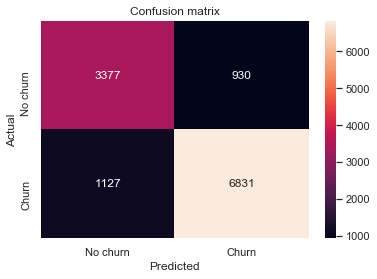

In [29]:

print ("\n Classification report : \n",classification_report(y2_test,y_pred3))
print ("Accuracy   Score : ",accuracy_score(y2_test,y_pred3))
print ("Recall   Score : ",recall_score(y2_test,y_pred3))
print("Precision Score : ",precision_score(y2_test,y_pred3))
#confusion matrix
conf_matrix = confusion_matrix(y2_test,y_pred3)
#roc_auc_score
model_roc_auc = roc_auc_score(y2_test,y_pred3) 

    
#plot confusion matrix
plt.figure()
matrix =sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
matrix.set_xticklabels(['No churn', 'Churn'])
matrix.set_yticklabels(['No churn', 'Churn'])
matrix.set_title('Confusion matrix')




In [30]:
# Save the model into a pickle
def pickle_file(output_file_name, object_to_pickle):
    with open(output_file_name, 'wb') as out_file:
        pickle.dump(object_to_pickle, out_file)

pickle_file('Women_churn_model_2', model2)